In [1]:
import math
import sqlite3
import struct
import datetime

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np
from scipy import signal, optimize
from tqdm.notebook import tnrange, tqdm

In [2]:
%matplotlib notebook

In [3]:
db = sqlite3.connect('waveform.sqlite3')

In [4]:
for run_id, start, end, count in db.execute('SELECT run_id, MIN(rx_ts), MAX(rx_ts), COUNT(*) FROM measurements GROUP BY run_id'):
    foo = lambda x: datetime.datetime.fromtimestamp(x/1000)
    start, end = foo(start), foo(end)
    print(f'Run {run_id:03d}: {start:%Y-%m-%d %H:%M:%S} - {end:%Y-%m-%d %H:%M:%S} ({str(end-start)[:-3]:>13}, {count*32:>9d}sp)')
last_run, n_records = run_id, count
sampling_rate = 1000.0

Run 000: 2020-01-30 14:24:25 - 2020-01-30 14:24:33 (  0:00:07.571,      6880sp)
Run 001: 2020-01-30 14:24:56 - 2020-01-30 14:25:25 (  0:00:28.305,      8992sp)
Run 002: 2020-01-30 14:25:33 - 2020-01-30 14:30:37 (  0:05:04.016,    290112sp)
Run 003: 2020-01-30 14:31:31 - 2020-01-30 14:37:59 (  0:06:27.900,    384192sp)
Run 004: 2020-01-30 14:38:30 - 2020-01-30 14:45:27 (  0:06:56.604,    417216sp)
Run 005: 2020-01-30 15:18:50 - 2020-01-30 15:19:01 (  0:00:10.690,     10240sp)
Run 006: 2020-01-30 16:37:15 - 2020-01-30 16:37:17 (  0:00:02.527,      2560sp)
Run 007: 2020-01-30 16:44:23 - 2020-01-30 16:58:48 (  0:14:24.293,    665600sp)
Run 008: 2020-01-30 17:06:35 - 2020-01-30 17:46:16 (  0:39:41.608,   2163168sp)
Run 009: 2020-01-30 17:46:20 - 2020-01-30 18:11:16 (  0:24:55.928,   1492480sp)
Run 010: 2020-01-30 18:11:39 - 2020-01-30 18:22:29 (  0:10:50.025,    642560sp)
Run 011: 2020-01-30 18:22:32 - 2020-01-30 19:33:52 (  1:11:20.495,   4280320sp)
Run 012: 2020-01-31 13:16:53 - 2020-01-3

In [5]:
par = lambda *rs: 1/sum(1/r for r in rs) # resistor parallel calculation

# FIXME: These are for the first prototype only!
vmeas_source_impedance = 330e3
vmeas_source_scale = 0.5

vcc = 15.0
vmeas_div_high = 27e3
vmeas_div_low = par(4.7e3, 10e3)
vmeas_div_voltage = vcc * vmeas_div_low / (vmeas_div_high + vmeas_div_low)
vmeas_div_impedance = par(vmeas_div_high, vmeas_div_low)

#vmeas_overall_factor = vmeas_div_impedance / (vmeas_source_impedance + vmeas_div_impedance)
v0 = 1.5746
v100 = 2.004
vn100 = 1.1452

adc_vcc = 3.3 # V
adc_fullscale = 4095

adc_val_to_voltage_factor = 1/adc_fullscale * adc_vcc

adc_count_to_vmeas = lambda x: (x*adc_val_to_voltage_factor - v0) / (v100-v0) * 100

In [6]:
limit = n_records
record_size = 32
skip_dropped_sections = False

data = np.zeros(limit*record_size)
data[:] = np.nan

last_seq = None
write_index = 0
for i, (seq, chunk) in tqdm(enumerate(db.execute(
        'SELECT seq, data FROM measurements WHERE run_id = ? ORDER BY rx_ts LIMIT ? OFFSET ?',
        (last_run, limit, n_records-limit))), total=n_records):
    
    if last_seq is None or seq == (last_seq + 1)%0xffff:
        last_seq = seq
        idx = write_index if skip_dropped_sections else i
        data[idx*record_size:(idx+1)*record_size] = np.frombuffer(chunk, dtype='<H')
        write_index += 1
        
    elif seq > last_seq:
        last_seq = seq
        # nans = np.empty((record_size,))
        # nans[:] = np.nan
        # data = np.append(data, nans) FIXME
        
data = (data * adc_val_to_voltage_factor - v0) / (v100-v0) * 100

In [7]:
data_not_nan = data[~np.isnan(data)]
np.sqrt(np.mean(np.square(data_not_nan)))

227.138252895397

<IPython.core.display.Javascript object>


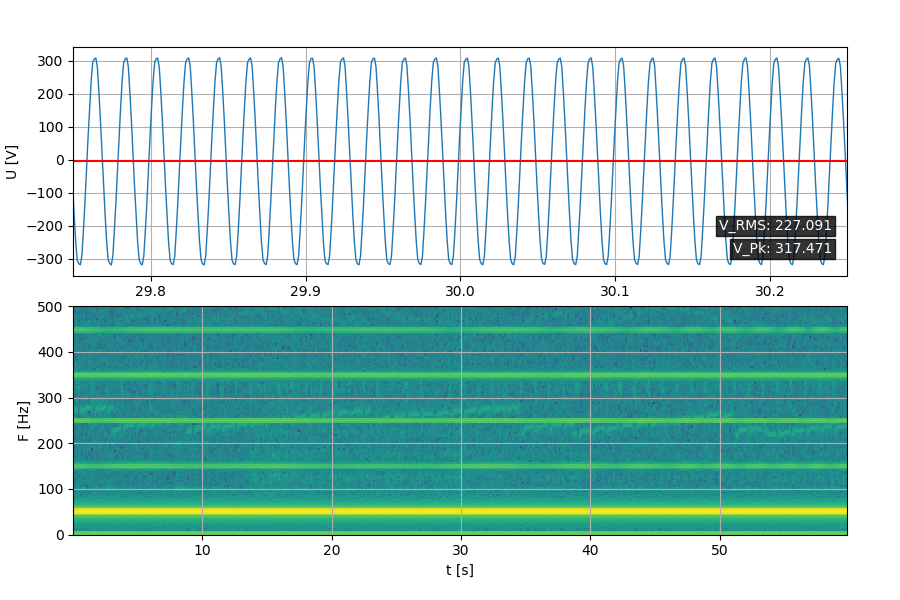

In [8]:
fig, (top, bottom) = plt.subplots(2, figsize=(9,6))
fig.tight_layout(pad=3, h_pad=0.1)

range_start, range_len = -300, 60 # [s]

data_slice = data[ int(range_start * sampling_rate) : int((range_start + range_len) * sampling_rate) ]

top.grid()
top.plot(np.linspace(0, range_len, int(range_len*sampling_rate)), data_slice, lw=1.0)
top.set_xlim([range_len/2-0.25, range_len/2+0.25])
mean = np.mean(data_not_nan)
rms = np.sqrt(np.mean(np.square(data_not_nan - mean)))
peak = np.max(np.abs(data_not_nan - mean))
top.axhline(mean, color='red')
bbox = {'facecolor': 'black', 'alpha': 0.8, 'pad': 2}
top.text(0, mean, f'mean: {mean:.3f}', color='white', bbox=bbox)
top.text(0.98, 0.2, f'V_RMS: {rms:.3f}', transform=top.transAxes, color='white', bbox=bbox, ha='right')
top.text(0.98, 0.1, f'V_Pk: {peak:.3f}', transform=top.transAxes, color='white', bbox=bbox, ha='right')

bottom.grid()
bottom.specgram(data_slice, Fs=sampling_rate)
top.set_ylabel('U [V]')
bottom.set_ylabel('F [Hz]')
bottom.set_xlabel('t [s]')
None

In [9]:
fs = sampling_rate # Hz
ff = 50 # Hz

analysis_periods = 10
window_len = fs * analysis_periods/ff
nfft_factor = 4
sigma = window_len/8 # samples

f, t, Zxx = signal.stft(data,
            fs = fs,
            window=('gaussian', sigma),
            nperseg = window_len,
            nfft = window_len * nfft_factor)

<IPython.core.display.Javascript object>


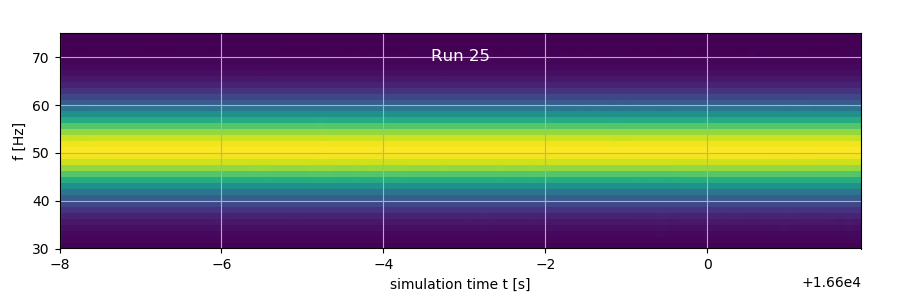

In [10]:
fig, ax = plt.subplots(figsize=(9, 3))
fig.tight_layout(pad=2, h_pad=0.1)

ax.pcolormesh(t[-200:-100], f[:250], np.abs(Zxx[:250,-200:-100]))
ax.set_title(f"Run {last_run}", pad=-20, color='white')
ax.grid()
ax.set_ylabel('f [Hz]')
ax.set_ylim([30, 75]) # Hz
ax.set_xlabel('simulation time t [s]')
None

In [11]:
f_t = t

n_f, n_t = Zxx.shape
# start, stop = 180, 220
# start, stop = 90, 110
# start, stop = 15, 35
# bounds_f = slice(start // 4 * nfft_factor, stop // 4 * nfft_factor)
f_min, f_max = 30, 70 # Hz
bounds_f = slice(np.argmax(f > f_min), np.argmin(f < f_max))


f_mean = np.zeros(Zxx.shape[1])
for le_t in tnrange(1, Zxx.shape[1] - 1):
    frame_f = f[bounds_f]
    frame_step = frame_f[1] - frame_f[0]
    time_step = f_t[1] - f_t[0]
    #if t == 10:
    #    axs[-1].plot(frame_f, frame_Z)
    frame_Z = np.abs(Zxx[bounds_f, le_t])
    # frame_f = f[180:220]
    # frame_Z = np.abs(Zxx[180:220, 40])
    # frame_f = f[15:35]
    # frame_Z = np.abs(Zxx[15:35, 40])
    # plt.plot(frame_f, frame_Z)

    # peak_f = frame_f[np.argmax(frame)]
    # plt.axvline(peak_f, color='red')

#         def gauss(x, *p):
#             A, mu, sigma, o = p
#             return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + o

    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    f_start = frame_f[np.argmax(frame_Z)]
    A_start = np.max(frame_Z)
    p0 = [A_start, f_start, 1.]
    try:
        coeff, var = optimize.curve_fit(gauss, frame_f, frame_Z, p0=p0)
        # plt.plot(frame_f, gauss(frame_f, *coeff))
        #print(coeff)
        A, mu, sigma, *_ = coeff
        f_mean[le_t] = mu
    except Exception:
        f_mean[le_t] = np.nan

<IPython.core.display.Javascript object>


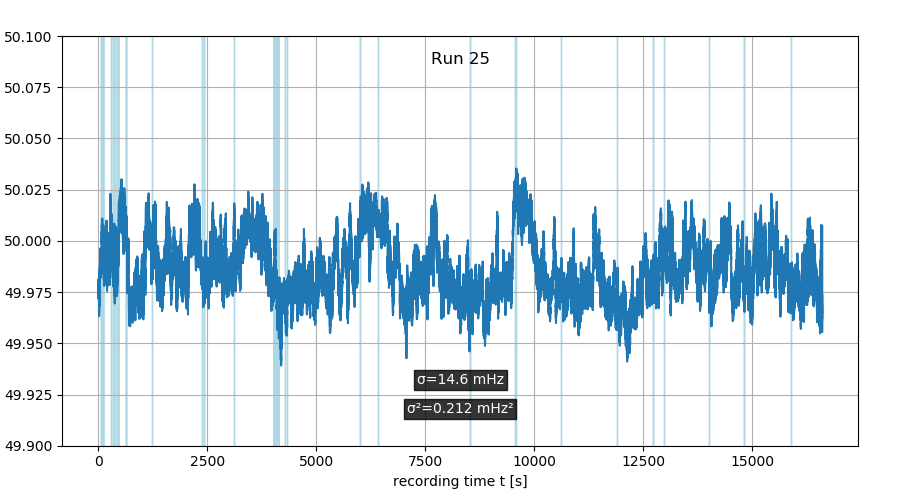

In [12]:
fig, ax = plt.subplots(figsize=(9, 5), sharex=True)
fig.tight_layout(pad=2.2, h_pad=0, w_pad=1)

label = f'Run {last_run}'
ax.plot(f_t[1:-1], f_mean[1:-1])

#     b, a = signal.butter(3,
#                          1/5, # Hz
#                          btype='lowpass',
#                          fs=1/time_step)
#     filtered = signal.lfilter(b, a, f_mean[1:-1], axis=0)
#     ax.plot(f_t[1:-1], filtered)

ax.set_title(label, pad=-20)
ax.set_ylabel('f [Hz]')
ax.grid()
if not label in ['off_frequency', 'sweep_phase_steps']:
    ax.set_ylim([49.90, 50.10])
    var = np.var(f_mean[~np.isnan(f_mean)][1:-1])
    ax.text(0.5, 0.08, f'σ²={var * 1e3:.3g} mHz²', transform=ax.transAxes, ha='center', color='white', bbox=bbox)
    ax.text(0.5, 0.15, f'σ={np.sqrt(var) * 1e3:.3g} mHz', transform=ax.transAxes, ha='center', color='white', bbox=bbox)

#         ax.text(0.5, 0.2, f'filt. σ²={np.var(filtered) * 1e3:.3g} mHz', transform=ax.transAxes, ha='center')
else:
    f_min, f_max = min(f_mean[1:-1]), max(f_mean[1:-1])
    delta = f_max - f_min
    ax.set_ylim(f_min - delta * 0.1, f_max + delta * 0.3)

for i in np.where(np.isnan(f_mean))[0]:
    ax.axvspan(f_t[i], f_t[i+1], color='lightblue')

ax.set_xlabel('recording time t [s]')
None

<IPython.core.display.Javascript object>


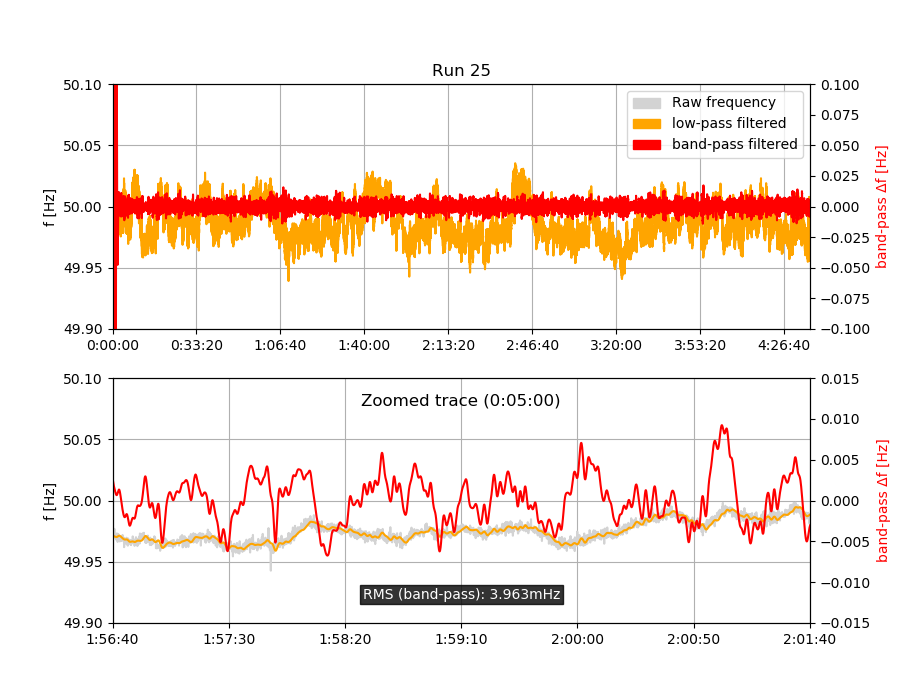

In [13]:
f_copy = np.copy(f_mean[1:-1])
f_copy[np.isnan(f_copy)] = np.mean(f_copy[~np.isnan(f_copy)])
b, a = signal.cheby2(7, 86, 100, 'low', output='ba', fs=1000)
filtered = signal.lfilter(b, a, f_copy)

b2, a2 = signal.cheby2(3, 30, 1, 'high', output='ba', fs=1000)
filtered2 = signal.lfilter(b2, a2, filtered)

fig, (ax2, ax1) = plt.subplots(2, figsize=(9,7))
ax1.plot(f_t[1:-1], f_copy, color='lightgray')
ax1.set_ylim([49.90, 50.10])
ax1.grid()
formatter = matplotlib.ticker.FuncFormatter(lambda s, x: str(datetime.timedelta(seconds=s)))
ax1.xaxis.set_major_formatter(formatter)
zoom_offx = 7000 # s
zoom_len = 300 # s
ax1.set_xlim([zoom_offx, zoom_offx + zoom_len])

ax1.plot(f_t[1:-1], filtered, color='orange')
ax1r = ax1.twinx()
ax1r.plot(f_t[1:-1], filtered2, color='red')
ax1r.set_ylim([-0.015, 0.015])
ax1.set_title(f'Zoomed trace ({datetime.timedelta(seconds=zoom_len)})', pad=-20)


ax2.set_title(f'Run {last_run}')
ax2.plot(f_t[1:-1], f_copy, color='orange')

ax2r = ax2.twinx()
ax2r.set_ylim([-0.1, 0.1])
ax2r.plot(f_t[1:-1], filtered2, color='red')
#ax2.plot(f_t[1:-1], filtered, color='orange', zorder=1)
ax2.set_ylim([49.90, 50.10])
ax2.set_xlim([0, f_t[-2]])
ax2.grid()
formatter = matplotlib.ticker.FuncFormatter(lambda s, x: str(datetime.timedelta(seconds=s)))
ax2.xaxis.set_major_formatter(formatter)

ax2.legend(handles=[
    patches.Patch(color='lightgray', label='Raw frequency'),
    patches.Patch(color='orange', label='low-pass filtered'),
    patches.Patch(color='red', label='band-pass filtered')])

#ax2r.spines['right'].set_color('red')
ax2r.yaxis.label.set_color('red')
#ax2r.tick_params(axis='y', colors='red')

#ax1r.spines['right'].set_color('red')
ax1r.yaxis.label.set_color('red')
#ax1r.tick_params(axis='y', colors='red')

ax1.set_ylabel('f [Hz]')
ax1r.set_ylabel('band-pass Δf [Hz]')
ax2.set_ylabel('f [Hz]')
ax2r.set_ylabel('band-pass Δf [Hz]')

# Cut out first 10min of filtered data to give filters time to settle
rms_slice = filtered2[np.where(f_t[1:] > 10*60)[0][0]:]
rms = np.sqrt(np.mean(np.square(rms_slice)))
ax1.text(0.5, 0.1, f'RMS (band-pass): {rms*1e3:.3f}mHz', transform=ax1.transAxes, color='white', bbox=bbox, ha='center')
None

In [14]:
chunk_size = 256

with open('filtered_freq.bin', 'wb') as f:
    for chunk in range(0, len(rms_slice), chunk_size):
        out_data = rms_slice[chunk:chunk+chunk_size]
        f.write(struct.pack(f'{len(out_data)}f',  *out_data))
        
with open('raw_freq.bin', 'wb') as f:
    for chunk in range(0, len(f_copy), chunk_size):
        out_data = f_copy[chunk:chunk+chunk_size]
        f.write(struct.pack(f'{len(out_data)}f',  *out_data))

In [17]:
def modulate(sequences, data)

(160118,)